# Variance-based sampling
- Idea: If Variance in 2 dimensions is the same, we know the points must be distributed the same in this dimension
    - variance of each dimension's variance will be low
- Flaws:
    - no approximation of uniform distribution -> inaccuarte detection of curves
    - only information we get is that if multiple dimensions have similar variance the variance of variances will be low
    - depends on Radius chosen

In [1]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
import os.path as osp
import os
import torch
import matplotlib as mpl

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA
import ipympl
import matplotlib
import ffmpeg


In [2]:
# jupyter nbextension install --py --sys-prefix --overwrite ipympl
# jupyter nbextension enable --py --sys-prefix ipympl

In [3]:
file = os.getcwd() + "/../variance_sampling.ipynb"

In [4]:
path = osp.join(osp.dirname(osp.realpath(file)), '..',
                                'data/ModelNet10')

pre_transform, transform = T.NormalizeScale(), T.SamplePoints(100_000)  # 1024

train_dataset = ModelNet(path, '10', True, transform, pre_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=4)

In [5]:
point_cloud = train_dataset[1] # 1000 = chair

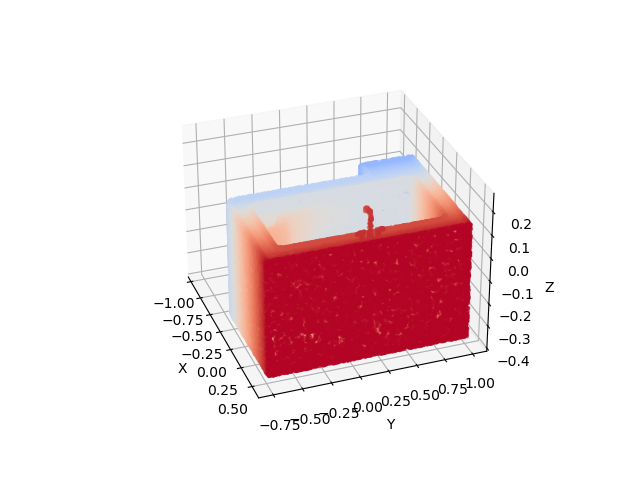

In [6]:
x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, marker='.',alpha=.5,cmap="coolwarm",c=x)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
ax.view_init(elev=30, azim=340)
plt.show(block=True)

In [7]:
def find_neighborhood(points, query_point, radius):
    # Calculate Euclidean distances between query_point and all points
    distances = torch.linalg.vector_norm(points - query_point,dim=1, ord=2)

    # Find indices of points within the specified radius
    neighborhood_indices = torch.where(distances <= radius)[0]

    # Return the points in the neighborhood
    neighborhood_points = points[neighborhood_indices]

    return neighborhood_points

Visualisation of neighbourhood function

In [8]:
point0 = point_cloud.pos[1]
nr_points = len(point_cloud.pos)
radius = .1
neighbours0 = find_neighborhood(point_cloud.pos, point0, radius)
print(len(neighbours0))

607


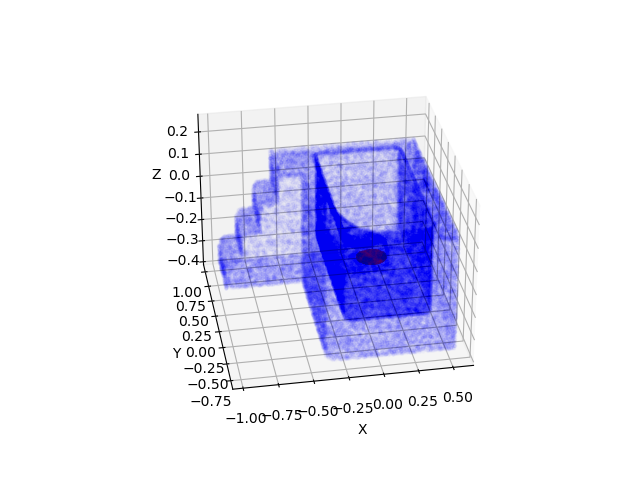

In [9]:

x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the points
ax.scatter(x, y, z, c='b', marker='.', alpha=0.01)
ax.scatter(neighbours0[:, 0], neighbours0[:, 1], neighbours0[:, 2], c='red', marker=".")
ax.scatter(point0[0], point0[1], point0[2], c='cyan', marker="*", s=80)

# plot only around radius
center = point0
x_min, x_max = center[0] - radius, center[0] + radius
y_min, y_max = center[1] - radius, center[1] + radius
z_min, z_max = center[2] - radius, center[2] + radius
# ax.set_xlim([x_min, x_max])
# ax.set_ylim([y_min, y_max])
# ax.set_zlim([z_min, z_max])

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=30, azim=260)
plt.show()

Local Variance

In [10]:
torch.var(neighbours0,axis=0)[0]

tensor(0.0025)

In [11]:
radius = .8
variances = np.zeros((nr_points,3))
for i,v in enumerate(point_cloud.pos):
    neighbours_i = find_neighborhood(point_cloud.pos, v, radius)
    variances[i,:] = torch.var(neighbours_i,axis=0)



KeyboardInterrupt



In [ ]:
# standardize variance, cannot start out with std bc don't know variances yet (depend on radius)
variances = variances / np.mean(variances,axis=0)
var_var = np.var(variances,axis=1)

In [ ]:
res = point_cloud.pos[var_var < .1]

In [ ]:
len(res)

In [ ]:
var_var

In [ ]:
var_direction = 0
x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]

x = res[:, 0]
y = res[:, 1]
z = res[:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the points
scatter = ax.scatter(x, y, z, marker='.',alpha=1,c=var_var[var_var <.1],cmap='coolwarm')

# plot only around radius

cbar = fig.colorbar(scatter)
label_axis = ["x","y","z"]
plt.title(f"Radius: {radius}, [var_var <0.1], 10M points")
# cbar.set_label(f"Variance: {label_axis[var_direction]}-axis")
# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
ax.view_init(elev=30, azim=200)
plt.show(block=True)

# Some informative features for edges/ curves

In [ ]:

test_curve

In [ ]:

x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the points
scatter = ax.scatter(x, y, z, marker='.',alpha=1,c=var_var,cmap='coolwarm')

# plot only around radius

cbar = fig.colorbar(scatter)
label_axis = ["x","y","z"]
# cbar.set_label(f"Variance: {label_axis[var_direction]}-axis")
# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
ax.view_init(elev=30, azim=340)
plt.show(block=True)

Curvature

In [ ]:
def approximate_curvature(p0, surrounding_points):
    """

    :param p0:
    :param surrounding_points:
    :return:
    """
    # Calculate weighted distances between p0 and surrounding points
    distances = torch.norm(surrounding_points - p0, dim=1)
    weights = torch.where(distances != 0, 1.0 / distances, 0)
    weights /= torch.sum(weights)
    weighted_average = torch.sum(weights.view(-1, 1) * surrounding_points, dim=0)

    print(weighted_average)

    # Calculate the partial derivatives using finite differences
    dx = weighted_average[0].item() - p0[0]
    dy = weighted_average[1].item() - p0[1]
    dz = weighted_average[2].item() - p0[2]

    # Calculate the Gaussian curvature using the formula:
    # K = (dx * dz - dy^2) / (norm(dx, dy, dz)^2)^2
    norm_squared = dx**2 + dy**2 + dz**2
    gaussian_curvature = (dx * dz - dy**2) / (norm_squared**2)

    return gaussian_curvature

# Example usage
# p0 = np.array([0.0, 0.0, 0.0])
# surrounding_points = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.1, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 1.5], [1.0, 0.0, 1.0]])
# curvature = approximate_curvature(p0, surrounding_points)
# print(curvature)


In [ ]:
approximate_curvature(point0,neighbours0)

In [ ]:
radius = 0.1
curvatures = np.zeros(nr_points)
for i,v in enumerate(point_cloud.pos):
    neighbours_i = find_neighborhood(point_cloud.pos, v, radius)
    curvatures[i] = approximate_curvature(v, neighbours_i)


In [ ]:
curvatures

In [ ]:

x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the points
scatter = ax.scatter(x, y, z, marker='.',alpha=1,c=curvatures,cmap='coolwarm')

# plot only around radius

cbar = fig.colorbar(scatter)
cbar.set_label('Curvature')
# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
plt.show(block=True)

In [ ]:
raise KeyboardInterrupt

In [ ]:
from matplotlib import animation
# http://matplotlib.org/mpl_examples/mplot3d/scatter3d_demo.py
def randrange(n, vmin, vmax):
    return (vmax - vmin) * np.random.rand(n) + vmin
n = 100
xx = randrange(n, 23, 32)
yy = randrange(n, 0, 100)
zz = randrange(n, -50, -25)

# Create a figure and a 3D Axes
fig = plt.figure()
ax = Axes3D(fig)

# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    ax.scatter(xx, yy, zz, marker='o', s=20, c="goldenrod", alpha=0.6)
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:

x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the points
scatter = ax.scatter(x, y, z, marker='.',alpha=1,c=curvatures,cmap='coolwarm')

# plot only around radius

cbar = fig.colorbar(scatter)
cbar.set_label('Curvature')
# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
plt.show()

# Trash

In [ ]:
def rotate_plot():
    for angle in range(0, 360 * 4 + 1):
        # Normalize the angle to the range [-180, 180] for display
        angle_norm = (angle + 180) % 360 - 180

        # Cycle through a full rotation of elevation, then azimuth, roll, and all
        elev = azim = roll = 0
        if angle <= 360:
            elev = angle_norm
        elif angle <= 360 * 2:
            azim = angle_norm
        elif angle <= 360 * 3:
            roll = angle_norm
        else:
            elev = azim = roll = angle_norm

        # Update the axis view and title
        ax.view_init(elev, azim, roll)
        plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

        plt.draw()
        plt.pause(.001)